In [1]:
from tensorflow.keras import layers, Model, preprocessing
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import GlobalAveragePooling2D
import numpy as np

from utils import make_predictions, evaluation, data_loader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
train_ds, val_ds, test_ds, class_names, img_size = data_loader.load_data(RANDOM_SEED, True, 0.75)

Found 15780 files belonging to 11 classes.
Using 11046 files for training.
Found 15780 files belonging to 11 classes.
Using 4734 files for validation.

Classes: ['tomato Fusarium Wilt', 'tomato spider mites', 'tomato verticillium wilt', 'tomato_bacterial_spot', 'tomato_early_blight', 'tomato_healthy_leaf', 'tomato_late_blight', 'tomato_leaf_curl', 'tomato_leaf_miner', 'tomato_leaf_mold', 'tomato_septoria_leaf']

✅ Balanced minority-only augmentation is ON

Counting class frequencies...
tomato Fusarium Wilt: 292
tomato spider mites: 456
tomato verticillium wilt: 376
tomato_bacterial_spot: 1201
tomato_early_blight: 1368
tomato_healthy_leaf: 1311
tomato_late_blight: 982
tomato_leaf_curl: 1335
tomato_leaf_miner: 1289
tomato_leaf_mold: 1342
tomato_septoria_leaf: 1094

Minority class: tomato Fusarium Wilt (count=292) → repeating 4× with augmentation

Minority class: tomato spider mites (count=456) → repeating 3× with augmentation

Minority class: tomato verticillium wilt (count=376) → repeat

In [3]:
# # percentage of ds compared to overall data
# train_size = 0
# val_size = 0
# test_size = 0
# for batch in train_ds:
#     train_size += batch[0].shape[0]
# for batch in val_ds:
#     val_size += batch[0].shape[0]
# for batch in test_ds:
#     test_size += batch[0].shape[0]
# total_size = train_size + val_size + test_size
# print(f"Train size: {train_size} ({(train_size/total_size)*100:.2f}%)")
# print(f"Validation size: {val_size} ({(val_size/total_size)*100:.2f}%)")
# print(f"Test size: {test_size} ({(test_size/total_size)*100:.2f}%)")

In [4]:
resNet50BaseArchitecture = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3), classes=len(class_names)) # include_top=True adds the classification layer

# Freezing the early layers (retain general features)
resNet50BaseArchitecture.trainable = True

for layer in resNet50BaseArchitecture.layers:
    # All layers before 'conv5_block1_1_conv' are frozen
    if layer.name == 'conv5_block1_1_conv':
        break
    layer.trainable = False

# Custom classification head
x = resNet50BaseArchitecture.output
x = GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

resNet50 = Model(inputs=resNet50BaseArchitecture.input, outputs=outputs)

resNet50.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resNet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
history = resNet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
425/425 [==============================] - 707s 2s/step - loss: 0.2819 - accuracy: 0.9140 - val_loss: 10.1882 - val_accuracy: 0.3302
Epoch 2/10
425/425 [==============================] - 719s 2s/step - loss: 0.1086 - accuracy: 0.9723 - val_loss: 3.7102 - val_accuracy: 0.6394
Epoch 3/10
425/425 [==============================] - 715s 2s/step - loss: 0.0556 - accuracy: 0.9842 - val_loss: 1.2379 - val_accuracy: 0.8252
Epoch 4/10
425/425 [==============================] - 733s 2s/step - loss: 0.0429 - accuracy: 0.9869 - val_loss: 1.2387 - val_accuracy: 0.8003
Epoch 5/10
425/425 [==============================] - 744s 2s/step - loss: 0.0310 - accuracy: 0.9907 - val_loss: 1.1743 - val_accuracy: 0.8834
Epoch 6/10
425/425 [==============================] - 796s 2s/step - loss: 0.0223 - accuracy: 0.9940 - val_loss: 1.0646 - val_accuracy: 0.8763
Epoch 7/10
425/425 [==============================] - 826s 2s/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 1.2442 - val_accuracy: 0.867

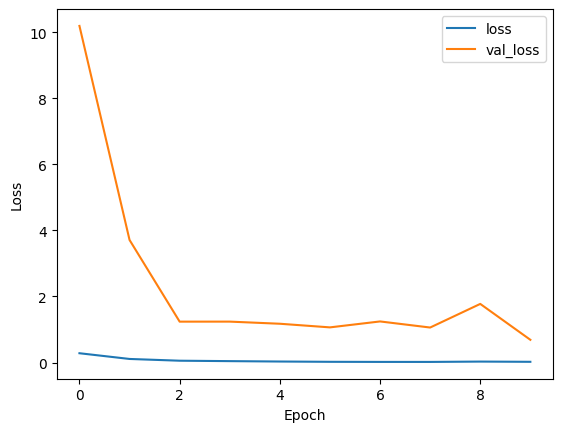

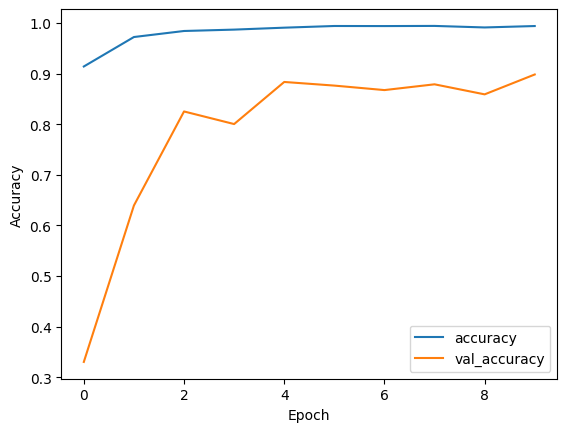

In [6]:
evaluation.plot_loss(history)
evaluation.plot_accuracy(history)

In [7]:
y_true, y_pred = make_predictions.predict_test_data(resNet50, test_ds)

1/1 [==============================] - 1s 1s/step


In [8]:
evaluation.make_classification_report(y_true, y_pred, class_names)

                          precision    recall  f1-score   support

    tomato Fusarium Wilt       1.00      0.93      0.96        55
     tomato spider mites       1.00      0.74      0.85        93
tomato verticillium wilt       1.00      0.88      0.94        69
   tomato_bacterial_spot       0.97      1.00      0.98       263
     tomato_early_blight       0.72      0.99      0.84       296
     tomato_healthy_leaf       0.97      1.00      0.98       284
      tomato_late_blight       1.00      0.12      0.22       227
        tomato_leaf_curl       0.84      1.00      0.91       271
       tomato_leaf_miner       1.00      0.97      0.99       299
        tomato_leaf_mold       0.84      1.00      0.91       284
    tomato_septoria_leaf       0.96      1.00      0.98       225

                accuracy                           0.90      2366
               macro avg       0.94      0.88      0.87      2366
            weighted avg       0.92      0.90      0.87      2366


Overal

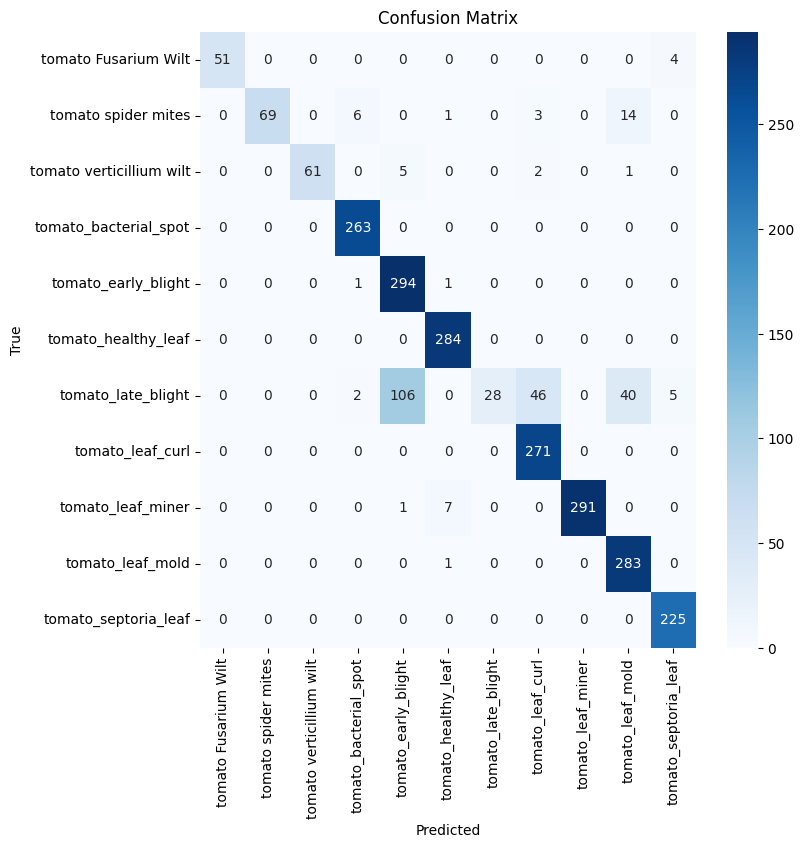

In [9]:
evaluation.make_confusion_matrix(y_true, y_pred, class_names)